Exercise 3.5:

Calculating Efficient Frontiers and Bootstrapping Efficient Frontiers

In [16]:
#Lets First Load our Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [17]:
logRet = pd.read_csv("m_logret_10stocks.txt", sep = "\t")
numAssets = len(logRet.columns) - 1
numObs = logRet.shape[0]
logRet.head()

,Date,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL
0,1/3/1994,0.048913,0.135255,-0.022896,0.062311,-0.012589,0.089236,-0.004332,0.000000,0.023481,0.049109
1,2/1/1994,0.048849,-0.014934,-0.009507,0.020685,0.059586,-0.002166,-0.014386,-0.026850,-0.013543,0.010790
2,3/1/1994,-0.040761,-0.078928,0.000873,0.162273,0.000000,-0.071433,-0.007948,0.014169,0.011634,-0.010790
3,4/4/1994,-0.044394,0.041945,0.002175,-0.073436,-0.059586,-0.117886,0.002286,0.022294,0.038426,-0.031135
4,5/2/1994,-0.009572,0.031889,0.015763,0.010089,0.121734,-0.018289,0.003406,0.041424,0.064941,0.057625


In [18]:
#need to define a function that will return sample statistics given a dataset

#Note, the "1:" in the splicing excludes the date column from the calculation
def sampleStat(data):
    sampleMean = data.iloc[:,1:].mean(axis = 0)
    sampleCov = data.iloc[:, 1:].cov()
    return (sampleMean, sampleCov)

In [19]:
#For now, lets just calculate these statistics on the time series as a whole
sampleMean, sampleCov = sampleStat(logRet)
print(sampleCov)


          AAPL      ADBE       ADP       AMD      DELL       GTW        HP  \
AAPL  0.004549  0.001328  0.000129  0.002612  0.001928  0.002242  0.000730   
ADBE  0.001328  0.004454  0.000516  0.001755  0.001145  0.001939  0.000694   
ADP   0.000129  0.000516  0.000788  0.000501  0.000377  0.000577  0.000295   
AMD   0.002612  0.001755  0.000501  0.007144  0.001996  0.003081  0.000902   
DELL  0.001928  0.001145  0.000377  0.001996  0.003522  0.002546  0.000546   
GTW   0.002242  0.001939  0.000577  0.003081  0.002546  0.006506  0.000467   
HP    0.000730  0.000694  0.000295  0.000902  0.000546  0.000467  0.002305   
IBM   0.000950  0.000447  0.000415  0.001580  0.001075  0.001024  0.000483   
MSFT  0.000899  0.000610  0.000324  0.001186  0.001605  0.001441  0.000089   
ORCL  0.001341  0.001176  0.000381  0.001540  0.001194  0.001110  0.000308   

           IBM      MSFT      ORCL  
AAPL  0.000950  0.000899  0.001341  
ADBE  0.000447  0.000610  0.001176  
ADP   0.000415  0.000324  0.00

In [92]:
#Lets define a function that takes in a sampleMean, sampleCov, targetReturn, and risk free rate
#and outputs the optimal Weight portfolio for the given expected output

#assume retMean, retCov, riskFree are given as matrices
def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
    one = np.ones((len(retMean),1))
    
    A = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@one)
    B = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@riskAdjMean)
    C = np.transpose(one)@inverseCov@one
    D = B*C - A**2

    numerator = B*inverseCov@one - A*inverseCov@riskAdjMean
    numerator += targetReturn*(C*inverseCov@riskAdjMean - A*inverseCov@one)
    optimalWeights = numerator * (1/D)

    return optimalWeights

In [93]:
rf = 0.0
targetReturn = 0.003 

#use ampersand to matrix multiply

#Turn needed df's into matrices for easy computation
riskFree = np.full((numAssets,1), rf)
sampleMeanMatrix = sampleMean.to_numpy()
sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
sampleCovMatrix = sampleCov.to_numpy()

#Call optimal function to find optimal weights for tReturn
optimalWeights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, targetReturn, riskFree)

In [94]:
print(optimalWeights)

[[ 0.07136165]
 [-0.02964316]
 [ 0.64982619]
 [-0.023669  ]
 [-0.19107218]
 [ 0.07856725]
 [ 0.16168683]
 [ 0.09650606]
 [ 0.16306989]
 [ 0.02336648]]


In [95]:
#Let's check that our expected return is correct, and the associated variance of the portfoli
expectedReturn = np.ndarray.item(np.transpose(optimalWeights)@sampleMeanMatrix)
expectedVariance = np.ndarray.item(np.transpose(optimalWeights)@sampleCovMatrix@optimalWeights)

print("Expected Return: " + str(expectedReturn))
print("Expected Variance: " + str(expectedVariance))

Expected Return: 0.002999999999999999
Expected Variance: 0.0006527962456876192


In [96]:
def bootStrapWeights(data, statisticFunction, targetReturn, riskFree, B = 500):
    #initialize some constants
    cumWeights = np.zeros((numAssets,1))
    riskFree = np.full((numAssets,1), rf)
    
    for i in range(1,B):
        iMean, iCov = sampleStat(data.sample(n = numObs, replace = True))
        iMeanMatrix = iMean.to_numpy()
        iMeanMatrix = iMeanMatrix.reshape((numAssets,1))
        iCovMatrix = iCov.to_numpy()
        iOptWeight = optimalWeight(iMeanMatrix, iCovMatrix, targetReturn, riskFree)
        cumWeights = np.add(cumWeights, iOptWeight)
    
    cumWeights = cumWeights * (1.0/B)
    return cumWeights
    

In [115]:
bootWeights = bootStrapWeights(logRet, sampleStat, targetReturn, riskFree)
print(bootWeights)


[[ 0.06771944]
 [-0.01603737]
 [ 0.61345926]
 [-0.03318296]
 [-0.12248011]
 [ 0.03443125]
 [ 0.16039651]
 [ 0.098632  ]
 [ 0.17565326]
 [ 0.01940873]]


In [103]:
#To create the efficient frontier, we need to create a grid of expected Returns
#and compute the minimum variance for each

muStar = np.linspace(-0.0002,0.02,101)
sig = np.empty(len(muStar))
mu = np.empty(len(muStar))
for idx, optRet in enumerate(muStar):
    iOptWeight = optimalWeight(sampleMeanMatrix, sampleCovMatrix, optRet, riskFree)
    isig = np.ndarray.item(np.transpose(iOptWeight)@sampleCovMatrix@iOptWeight)
    mu[idx] = np.ndarray.item(np.transpose(iOptWeight)@sampleMeanMatrix)
    sig[idx] = isig
    
    

<function matplotlib.pyplot.show(close=None, block=None)>

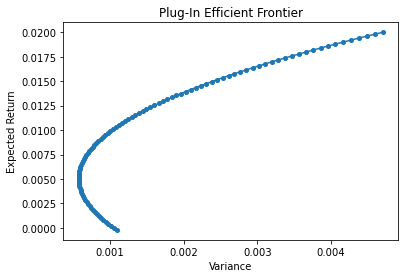

In [104]:
#Plot this EF

plt.title("Plug-In Efficient Frontier") 
plt.xlabel("Variance") 
plt.ylabel("Expected Return")
plt.plot(sig, mu, marker = "o", markersize = 4, label = "Plug-in")
plt.show

In [107]:
#Now do the same for the bootstrapped samples
bootSig = np.empty(len(muStar))
bootMu = np.empty(len(muStar))
for idx, optRet in enumerate(muStar):
    iOptWeight = bootStrapWeights(logRet, sampleStat, optRet, riskFree)
    isig = np.ndarray.item(np.transpose(iOptWeight)@sampleCovMatrix@iOptWeight)
    bootMu[idx] = np.ndarray.item(np.transpose(iOptWeight)@sampleMeanMatrix)
    bootSig[idx] = isig


<function matplotlib.pyplot.show(close=None, block=None)>

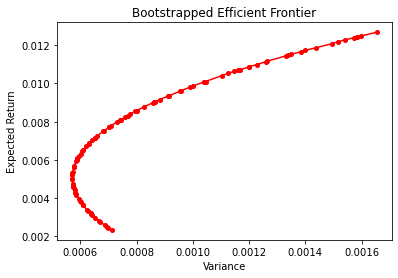

In [113]:
plt.title("Bootstrapped Efficient Frontier") 
plt.xlabel("Variance") 
plt.ylabel("Expected Return")
#dont plot mu, plot bootMu, i.e. weight*return
plt.plot(bootSig, bootMu, color = "red", marker = "o", markersize = 4, label = "Bootstrap")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

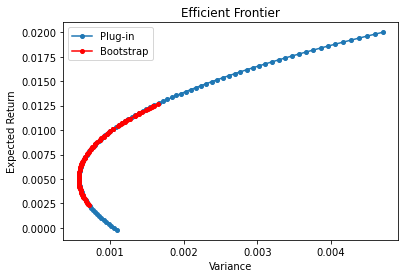

In [114]:
#Now lets overlay these two EF
plt.title("Efficient Frontier") 
plt.xlabel("Variance") 
plt.ylabel("Expected Return")
plt.plot(sig, mu, marker = "o", markersize = 4, label = "Plug-in")
plt.plot(bootSig, bootMu, color = "red", marker = "o", markersize = 4, label = "Bootstrap")
plt.legend()
plt.show


As we can see, the Bootstrapped frontier is essentially in line with the plug-in values, except that it's only a subset of the plug-in expected returns. The reason is that there is a signiciant difference between the specified expected return and the actual expected return when calculating \bar{mu}^T \hat{mu}.